In [1]:
# number of CPUs to be used
NCPU=20

## Load the dataset

In [2]:
import json, gzip
import numpy as np

aa2idx = {'A':0, 'R':1, 'N':2, 'D':3, 'C':4, 'Q':5, 'E':6, 'G':7, 'H':8, 'I':9,
          'L':10, 'K':11, 'M':12, 'F':13, 'P':14, 'S':15, 'T':16, 'W':17, 'Y':18, 'V':19}

# read .json file
with gzip.open('../data/phipsi.json.gz', 'rb') as f:
    dataset = json.load(f)

# reduse dataset to a list for simpler access
dataset = dataset['phipsi10882']

# convert data to numpy arrays skipping first and last residues
for item in dataset:
    n = len(item['sequence'])
    item['sequence'] = np.array([aa2idx[aa] for aa in item['sequence'][1:n-1]], dtype=np.int8)
    item['phi'] = np.array(item['phi'], dtype=np.float32)[1:n-1]
    item['psi'] = np.array(item['psi'], dtype=np.float32)[1:n-1]
    
    # convert (phi,psi) to their sin() and cos()
    # (4 numbers per angle pair)
    item['avec'] = np.vstack([
        np.sin(item['phi']).T,
        np.cos(item['phi']).T,
        np.sin(item['psi']).T,
        np.cos(item['psi']).T ]).T

## Train / test split

In [3]:
from sklearn.model_selection import train_test_split

# 90% train, 10% test
train,test = train_test_split(dataset, test_size=0.1, random_state=42)

print("Train size: {} proteins".format(len(train)))
print("Test size: {} proteins".format(len(test)))


Train size: 9793 proteins
Test size: 1089 proteins


## K-means clusters from angle vectors

We now use the train set to split (&phi;,&psi;) angle pairs into 20 clusters. Test set will be used further to assess performance of the method.

In [4]:
from sklearn.cluster import KMeans

# combine all proteins in the training set
# into one vector X
X = np.vstack([item['avec'] for item in train])

# split into 20 clusters
kmeans = KMeans(n_clusters=20, max_iter=5, random_state=42, n_jobs=NCPU).fit(X)

## Auxiliary functions

The two functions below will help extracting X,Y training vectors from the dataset, given WINDOW size and clustering results.

In [5]:
# given WINDOW, extract feature vector X from the dataset
def getX(dataset, WINDOW):
    
    for item in dataset:
        seq = item['sequence']
        l = len(seq)
        # split current sequence in all possible
        # chunks of length WINDOW
        chunks = np.vstack([w for shift in range(0,WINDOW,1) 
                            for w in np.split(seq[shift:],range(0,l,WINDOW)) 
                            if len(w) == WINDOW])
        # 1-hot encode these chunks
        # and save in a temp. vector
        item['X'] = np.array(np.eye(20)[chunks], dtype=np.int8).reshape((chunks.shape[0],-1))
    
    # stack X vectors from all proteins together
    X = np.vstack([item['X'] for item in dataset])

    # delete temp. vectors
    for item in dataset:
        del item['X']
    
    return X


In [6]:
# given WINDOW and clustering object KMEANS,
# extract label vector Y from the dataset
def getY(dataset, WINDOW, KMEANS):

    for item in dataset:
        l = len(item['sequence'])
        # assign angle vectors to clusters
        abin = np.array(kmeans.predict(item['avec']), dtype=np.int8)
        # for every WINDOW position, pick the element in the middle and
        # save corresponding cluster ID in temp. item['Y']
        item['Y'] = np.hstack([w[WINDOW//2] 
                               for shift in range(0,WINDOW,1) 
                               for w in np.split(abin[shift:],range(0,l,WINDOW)) 
                               if len(w) == WINDOW])
    # stack Y vectors from all proteins together
    Y = np.hstack([item['Y'] for item in dataset])
    
    # delete temp. vectors
    for item in dataset:
        del item['Y']
    
    return Y

We will also need similar functions to extract single joint vectors for &phi; and &psi;.

In [7]:
# given WINDOW, extract phi
def getPHI(dataset, WINDOW):
    
    for item in dataset:
        phi = item['phi']
        l = len(phi)
        item['phi_temp'] = np.hstack([w[WINDOW//2] 
                                      for shift in range(0,WINDOW,1) 
                                      for w in np.split(phi[shift:],range(0,l,WINDOW)) 
                                      if len(w) == WINDOW])

    PHI = np.hstack([item['phi_temp'] for item in dataset])

    for item in dataset:
        del item['phi_temp']
    
    return PHI


In [8]:
# given WINDOW, extract psi
def getPSI(dataset, WINDOW):
    
    for item in dataset:
        psi = item['psi']
        l = len(psi)
        item['psi_temp'] = np.hstack([w[WINDOW//2] 
                                      for shift in range(0,WINDOW,1) 
                                      for w in np.split(psi[shift:],range(0,l,WINDOW)) 
                                      if len(w) == WINDOW])

    PSI = np.hstack([item['psi_temp'] for item in dataset])

    for item in dataset:
        del item['psi_temp']
    
    return PSI

## Logistic regression

In [9]:
WINDOW = 15

X_train = getX(train, WINDOW)
Y_train = getY(train, WINDOW, kmeans)

print("X_train shape: {}".format(X_train.shape))
print("Y_train shape: {}".format(Y_train.shape))

X_test = getX(test, WINDOW)
Y_test = getY(test, WINDOW, kmeans)

print("X_test shape: {}".format(X_test.shape))
print("Y_test shape: {}".format(Y_test.shape))


X_train shape: (2008162, 300)
Y_train shape: (2008162,)
X_test shape: (224496, 300)
Y_test shape: (224496,)


Applying regular ```sklearn```'s ```LogisticRegression``` to the entire training set is quite time- and memory- consuming. A workaround is mini batch logistic regression accessible via ```SGDClassifier``` class with ```loss``` parameter set to ```'log'```

In [10]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=1000, tol=1e-3, loss='log', n_jobs=NCPU)
sgd.fit(X_train, Y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=20, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)

## Analysis of the results

### Cross-entropy

First, let's compare losses (cross-entropy in this context) between training and test sets.

In [11]:
from sklearn.metrics import log_loss

loss_train = log_loss(Y_train, sgd.predict_proba(X_train))
loss_test = log_loss(Y_test, sgd.predict_proba(X_test))

print("Train/test losses: {:.5f} / {:.5f}".format(loss_train, loss_test))

Train/test losses: 2.11776 / 2.12209


### RMSE

The two losses are quite close to each other, which suggests that overfitting is very marginal (if any). Our goal, however, is to predict backbone torsions (&phi;,&psi;). So, we need to map the predicted cluster labels back to angles and calculate root-mean-square error RMSE.

In [12]:
# reference phi,psi
phi_ref = getPHI(test, WINDOW)
psi_ref = getPSI(test, WINDOW)

The simplest way to extract dihedrals from predictions is to use centroids of the most probable predicted clusters.

In [13]:
# predict cluster label and extract (phi,psi)
# of the corresponding centroid
Y_test_pred = (kmeans.cluster_centers_)[sgd.predict(X_test)]


Each row of ```Y_test_pred``` is angle vector **v**=(cos(&phi;),sin(&phi;),cos(&psi;),sin(&psi;)). We apply ```np.atan2``` function to convert (sin(...),cos(...)) pairs back to corresponding angles. 

In [14]:
# convert angle vectors to phi,psi angles
phi_pred = np.arctan2(Y_test_pred[:,0], Y_test_pred[:,1])
psi_pred = np.arctan2(Y_test_pred[:,2], Y_test_pred[:,3])


Finally, calculate RMSE

In [15]:
def ang_rmse(ref, pred):
    # don't forget about periodicity!
    rmse = np.sqrt(np.sum(np.square(np.minimum(
        np.abs(pred - ref), 
        np.abs(pred - ref + 2*np.pi),
        np.abs(pred - ref - 2*np.pi))))
                   / ref.shape[0])
    return rmse

print("rmse(phi)= {:.3f}".format(ang_rmse(phi_ref, phi_pred) * 180 / np.pi))
print("rmse(psi)= {:.3f}".format(ang_rmse(psi_ref, psi_pred) * 180 / np.pi))


rmse(phi)= 50.360
rmse(psi)= 99.055


A different strategy for deriving predicted (&phi;,&psi;) angles is to use predicted probabilities of ALL clusters and calculate weighted average of ALL cluster centroids.

In [16]:
# calculate weighted averages
avec = np.matmul(sgd.predict_proba(X_test), kmeans.cluster_centers_)

# vectors of weighted averages avec[..] might not represent
# true sin(.),cos(.) pairs any more -- need to normalize them
norm_phi = np.sqrt(np.square(avec[:,0])+np.square(avec[:,1]))
norm_psi = np.sqrt(np.square(avec[:,2])+np.square(avec[:,3]))
phi_pred = np.arctan2(avec[:,0] / norm_phi, avec[:,1] / norm_phi)
psi_pred = np.arctan2(avec[:,2] / norm_psi, avec[:,3] / norm_psi)

# new error estimates
print("rmse(phi)= {:.3f}".format(ang_rmse(phi_ref, phi_pred) * 180 / np.pi))
print("rmse(psi)= {:.3f}".format(ang_rmse(psi_ref, psi_pred) * 180 / np.pi))

rmse(phi)= 44.543
rmse(psi)= 87.360


Just another way of calculating averages gives 4-5° improvement in &phi; and 9-10° improvement in &psi;!

### RMSE by residue type

In [17]:
for aa,idx in aa2idx.items():
    rphi = ang_rmse(phi_ref[X_test[:,(WINDOW//2)*20+idx]==1],
                    phi_pred[X_test[:,(WINDOW//2)*20+idx]==1])*180/np.pi
    rpsi = ang_rmse(psi_ref[X_test[:,(WINDOW//2)*20+idx]==1],
                    psi_pred[X_test[:,(WINDOW//2)*20+idx]==1])*180/np.pi
    print("{}\t{:.3f}\t{:.3f}".format(aa, rphi, rpsi))

A	33.162	83.260
R	36.164	81.500
N	56.956	75.815
D	43.595	81.079
C	39.949	89.042
Q	37.551	79.231
E	32.804	78.018
G	105.538	118.810
H	43.911	80.851
I	26.648	81.725
L	27.445	80.686
K	37.121	80.685
M	32.993	83.024
F	37.087	86.299
P	12.296	93.186
S	39.071	98.201
T	30.332	95.355
W	35.018	87.789
Y	37.565	86.377
V	28.142	82.637


Glycine (G) looks especially bad.

### Figures

In [18]:
# errors on a per cluster basis
rmse_phi_clust = {}
rmse_psi_clust = {}

for idx in range(0,kmeans.cluster_centers_.shape[0]):
    rmse_phi_clust[idx] = ang_rmse(phi_ref[Y_test == idx], phi_pred[Y_test == idx])
    rmse_psi_clust[idx] = ang_rmse(psi_ref[Y_test == idx], psi_pred[Y_test == idx])
    

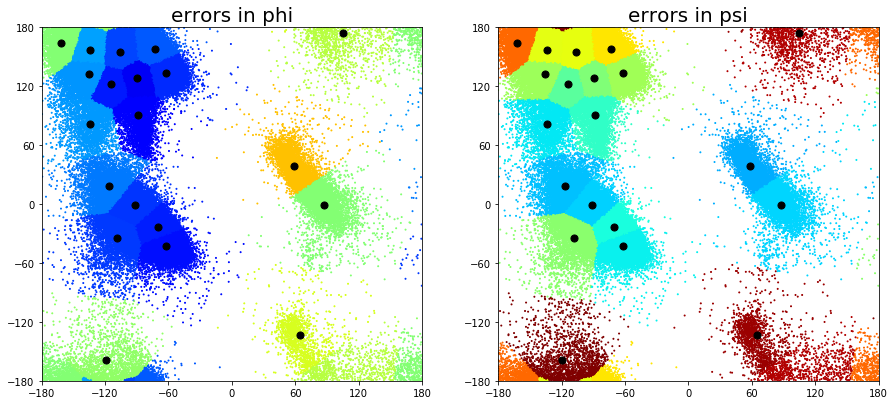

In [22]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# cluster centers
cent = kmeans.cluster_centers_
cphi = np.arctan2(cent[:,0], cent[:,1]) * 180 / np.pi
cpsi = np.arctan2(cent[:,2], cent[:,3]) * 180 / np.pi

# color vectors (rmse)
col_phi = np.array([rmse_phi_clust[idx] for idx in Y_test]) * 180 / np.pi
col_psi = np.array([rmse_psi_clust[idx] for idx in Y_test]) * 180 / np.pi

matplotlib.rcParams['image.cmap'] = 'jet'

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6.5)

# set style
for col in (0,1):
    ax[col].set_xlim([-180,180])
    ax[col].set_ylim([-180,180])
    ax[col].set_xticks((-180,-120,-60,0,60,120,180))
    ax[col].set_yticks((-180,-120,-60,0,60,120,180))

ax[0].set_title("errors in phi", fontsize=20)
ax[0].scatter(phi_ref*180/np.pi, psi_ref*180/np.pi, c=col_phi, s=1, vmin=0, vmax=180)
ax[0].scatter(cphi, cpsi, c='black', s=50)

ax[1].set_title("errors in psi", fontsize=20)
ax[1].scatter(phi_ref*180/np.pi, psi_ref*180/np.pi, c=col_psi, s=1, vmin=0, vmax=180)
ax[1].scatter(cphi, cpsi, c='black', s=50)

plt.show()